In [1]:
!nvidia-smi

Wed May  6 08:05:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install kaggle
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle
!git clone https://github.com/ifayost/cdb_pneumonia.git
!python cdb_pneumonia/download_data.py
!mv chest_xray cdb_pneumonia
!python cdb_pneumonia/transform_images.py cdb_pneumonia/chest_xray train
!python cdb_pneumonia/transform_images.py cdb_pneumonia/chest_xray val
!python cdb_pneumonia/transform_images.py cdb_pneumonia/chest_xray test
print('Done')

Cloning into 'cdb_pneumonia'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 42 (delta 4), reused 12 (delta 1), pack-reused 25
Unpacking objects: 100% (42/42), done.
100% 5216/5216 [02:28<00:00, 35.08it/s]
100% 16/16 [00:00<00:00, 40.55it/s]
100% 624/624 [00:17<00:00, 35.25it/s]
Done


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

plt.style.use('seaborn')

In [0]:
PATH = './cdb_pneumonia/chest_xray'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ColorJitter(brightness=(0.9,1.1), contrast=(1,1.1)),
        transforms.ToTensor()]),
    'val':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()]),
    'test':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = np.array(image_datasets['train'].classes)
class_samples = {x: np.sum([1 for _ in os.listdir(os.path.join(PATH, 'train', x))])
                for x in class_names}
weights = 1. / torch.tensor(list(class_samples.values()), dtype=torch.float).to(device)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True,
                                              batch_size=16, num_workers=2)
              for x in ['train', 'val', 'test']}

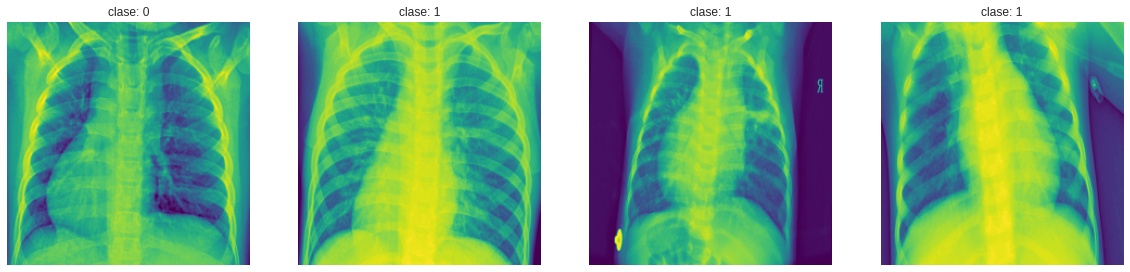

In [43]:
fig = plt.figure(figsize=(20,8))
for i in range(4):
  inputs, classes = next(iter(dataloaders['train']))
  ax = fig.add_subplot(1,4,i+1)
  ax.imshow(inputs.numpy()[0,0], cmap='viridis')
  ax.set_title(f'clase: {classes.numpy()[0]}');
  ax.axis('off');

In [5]:
vgg16 = torchvision.models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
  param.requires_grad = False
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
#vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg16 = nn.Sequential(nn.Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), vgg16) # vgg16+1conv_224x224_e5.pt acc: 0.92467
#vgg16 = nn.Sequential(nn.Conv2d(1, 3, kernel_size=(3, 3), stride=(2, 2), padding=0),
#                      nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=0),
#                      vgg16) #vgg16+2conv_908x908_e5.pt acc: 0.89

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
vgg16.load_state_dict(torch.load('/content/drive/My Drive/vgg16+1conv_224x224_e5.pt'))
vgg16 = vgg16.to(device)

In [0]:
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001)

In [0]:
n_epochs = 10

best_loss = 999999

train_loss, eval_loss = [],[]
for epoch in range(n_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16.train()
        else:
            vgg16.eval()
            
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    train_loss.append(loss.detach().to('cpu').numpy())
                else:
                    loss = loss.to('cpu').numpy()
                    eval_loss.append(loss)
                    if loss < best_loss:
                      torch.save(vgg16.state_dict(), 
                                 f'/content/drive/My Drive/vgg16+2conv_908x908_e{epoch}.pt')
                      best_loss = loss
                      if best_loss == 0:
                        break

In [0]:
t_loss = np.array(train_loss)
e_loss = np.array(eval_loss)

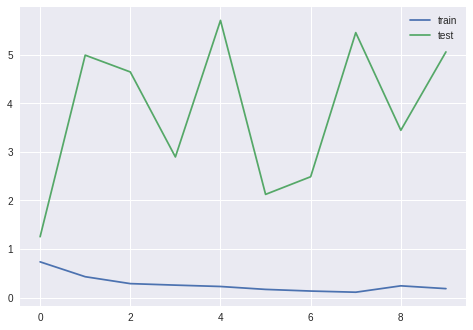

In [0]:
plt.plot(np.mean(t_loss.reshape(-1,len(t_loss)//n_epochs), axis=1), label='train');
plt.plot(np.mean(e_loss.reshape(-1,len(e_loss)//n_epochs), axis=1), label='test');
plt.legend();

In [0]:
vgg16.eval()
aciertos = []
random = []
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    outputs = vgg16(inputs)
    _, preds = torch.max(outputs, 1)
    aciertos.extend([i==j for i,j in zip(preds.to('cpu').numpy(), labels.numpy())])
    random.extend([np.random.randint(0,1)== i for i in labels.numpy()])

In [0]:
print(f'VGG16 Accuracy: {np.sum(aciertos)/len(aciertos)}')
print(f'Random Accuracy: {np.sum(random)/len(random)}')

VGG16 Accuracy: 0.8125
Random Accuracy: 0.5


In [16]:
vgg16.eval()
predicciones = []
probs = [] 
true = []
random = []
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    outputs = vgg16(inputs)
    _, preds = torch.max(outputs, 1)
    predicciones.extend(preds.to('cpu').numpy())
    probs.extend(F.softmax(outputs[:,1]).detach().to('cpu').numpy())
    true.extend(labels.numpy())
    random.extend([np.random.randint(0,1)== i for i in labels.numpy()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [9]:
print(f'VGG16 Accuracy: {np.sum([i==j for i,j in zip(predicciones,true)])/len(predicciones)}')
print(f'Random Accuracy: {np.sum(random)/len(random)}')

VGG16 Accuracy: 0.9246794871794872
Random Accuracy: 0.375


In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def confusion_mat(y_true,y_pred,labels):
    cm=confusion_matrix(y_true,y_pred,labels=labels)
    ax= plt.subplot()
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, ax = ax, fmt='', cmap='viridis');
    ax.set_xlabel('Predicted labels'); 
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.set_xticklabels(labels,rotation=0); 
    ax.set_yticklabels(labels,rotation=90);

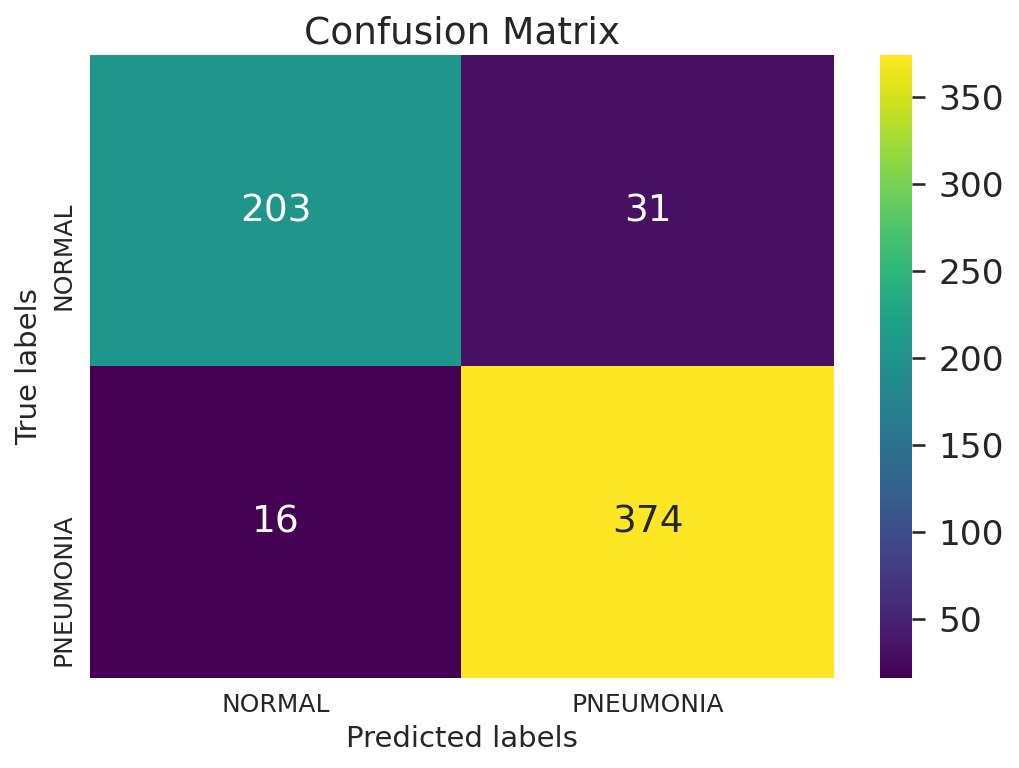

In [47]:
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig = plt.figure(dpi=150)
confusion_mat(class_names[true], class_names[predicciones], class_names)

Text(0, 0.5, 'Verdaderos positivos')

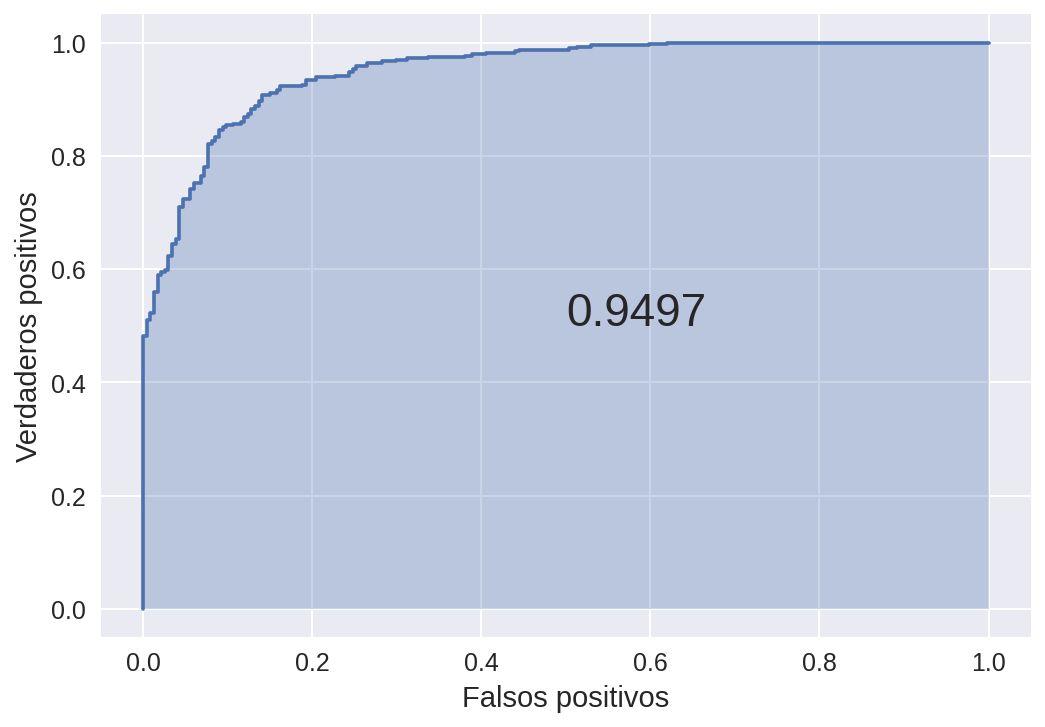

In [40]:
from sklearn.metrics import roc_curve, auc
roc = roc_curve(true, probs)
auc_ = auc(roc[0], roc[1])
plt.figure(dpi=150)
plt.plot(roc[0],roc[1])
plt.fill_between(roc[0], np.zeros(len(roc[1])), roc[1], alpha = 0.3)
plt.text(0.5, 0.5, f'{round(auc_, 5)}', {'fontsize':22})
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')

# Captum

In [7]:
!pip install captum

     |████████████████████████████████| 1.4MB 6.6MB/s 


In [0]:
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import Occlusion
from captum.attr import Saliency
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
vgg16 = vgg16.eval()
#ig = IntegratedGradients(vgg16)
#noise_tunnel = NoiseTunnel(ig)
occlusion = Occlusion(vgg16)
#saliency = Saliency(vgg16)

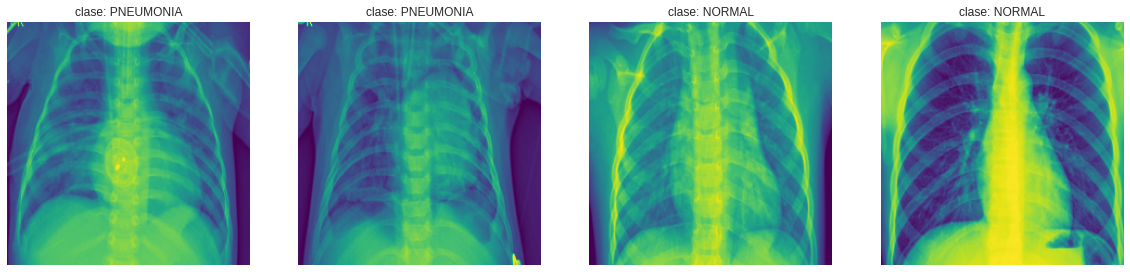

In [19]:
torch.manual_seed(1)
cls1, cls0 = [],[]
fig = plt.figure(figsize=(20,10))
i=1
for inputs, classes in dataloaders['test']:
  for inp, cls in zip(inputs, classes):
    cls = cls.numpy()
    if len(cls1) < 2 and cls == 1:
      cls1.append(inp)
      ax = fig.add_subplot(140+i)
      ax.imshow(inp.squeeze().cpu().detach().numpy(), cmap='viridis')
      ax.set_title(f'clase: {class_names[cls]}');
      plt.axis('off');
      i+=1
    elif len(cls0) < 2 and cls == 0:
      cls0.append(inp)
      ax = fig.add_subplot(140+i)
      ax.imshow(inp.squeeze().cpu().detach().numpy(), cmap='viridis')
      ax.set_title(f'clase: {class_names[cls]}');
      plt.axis('off');
      i+=1
    else:
      break

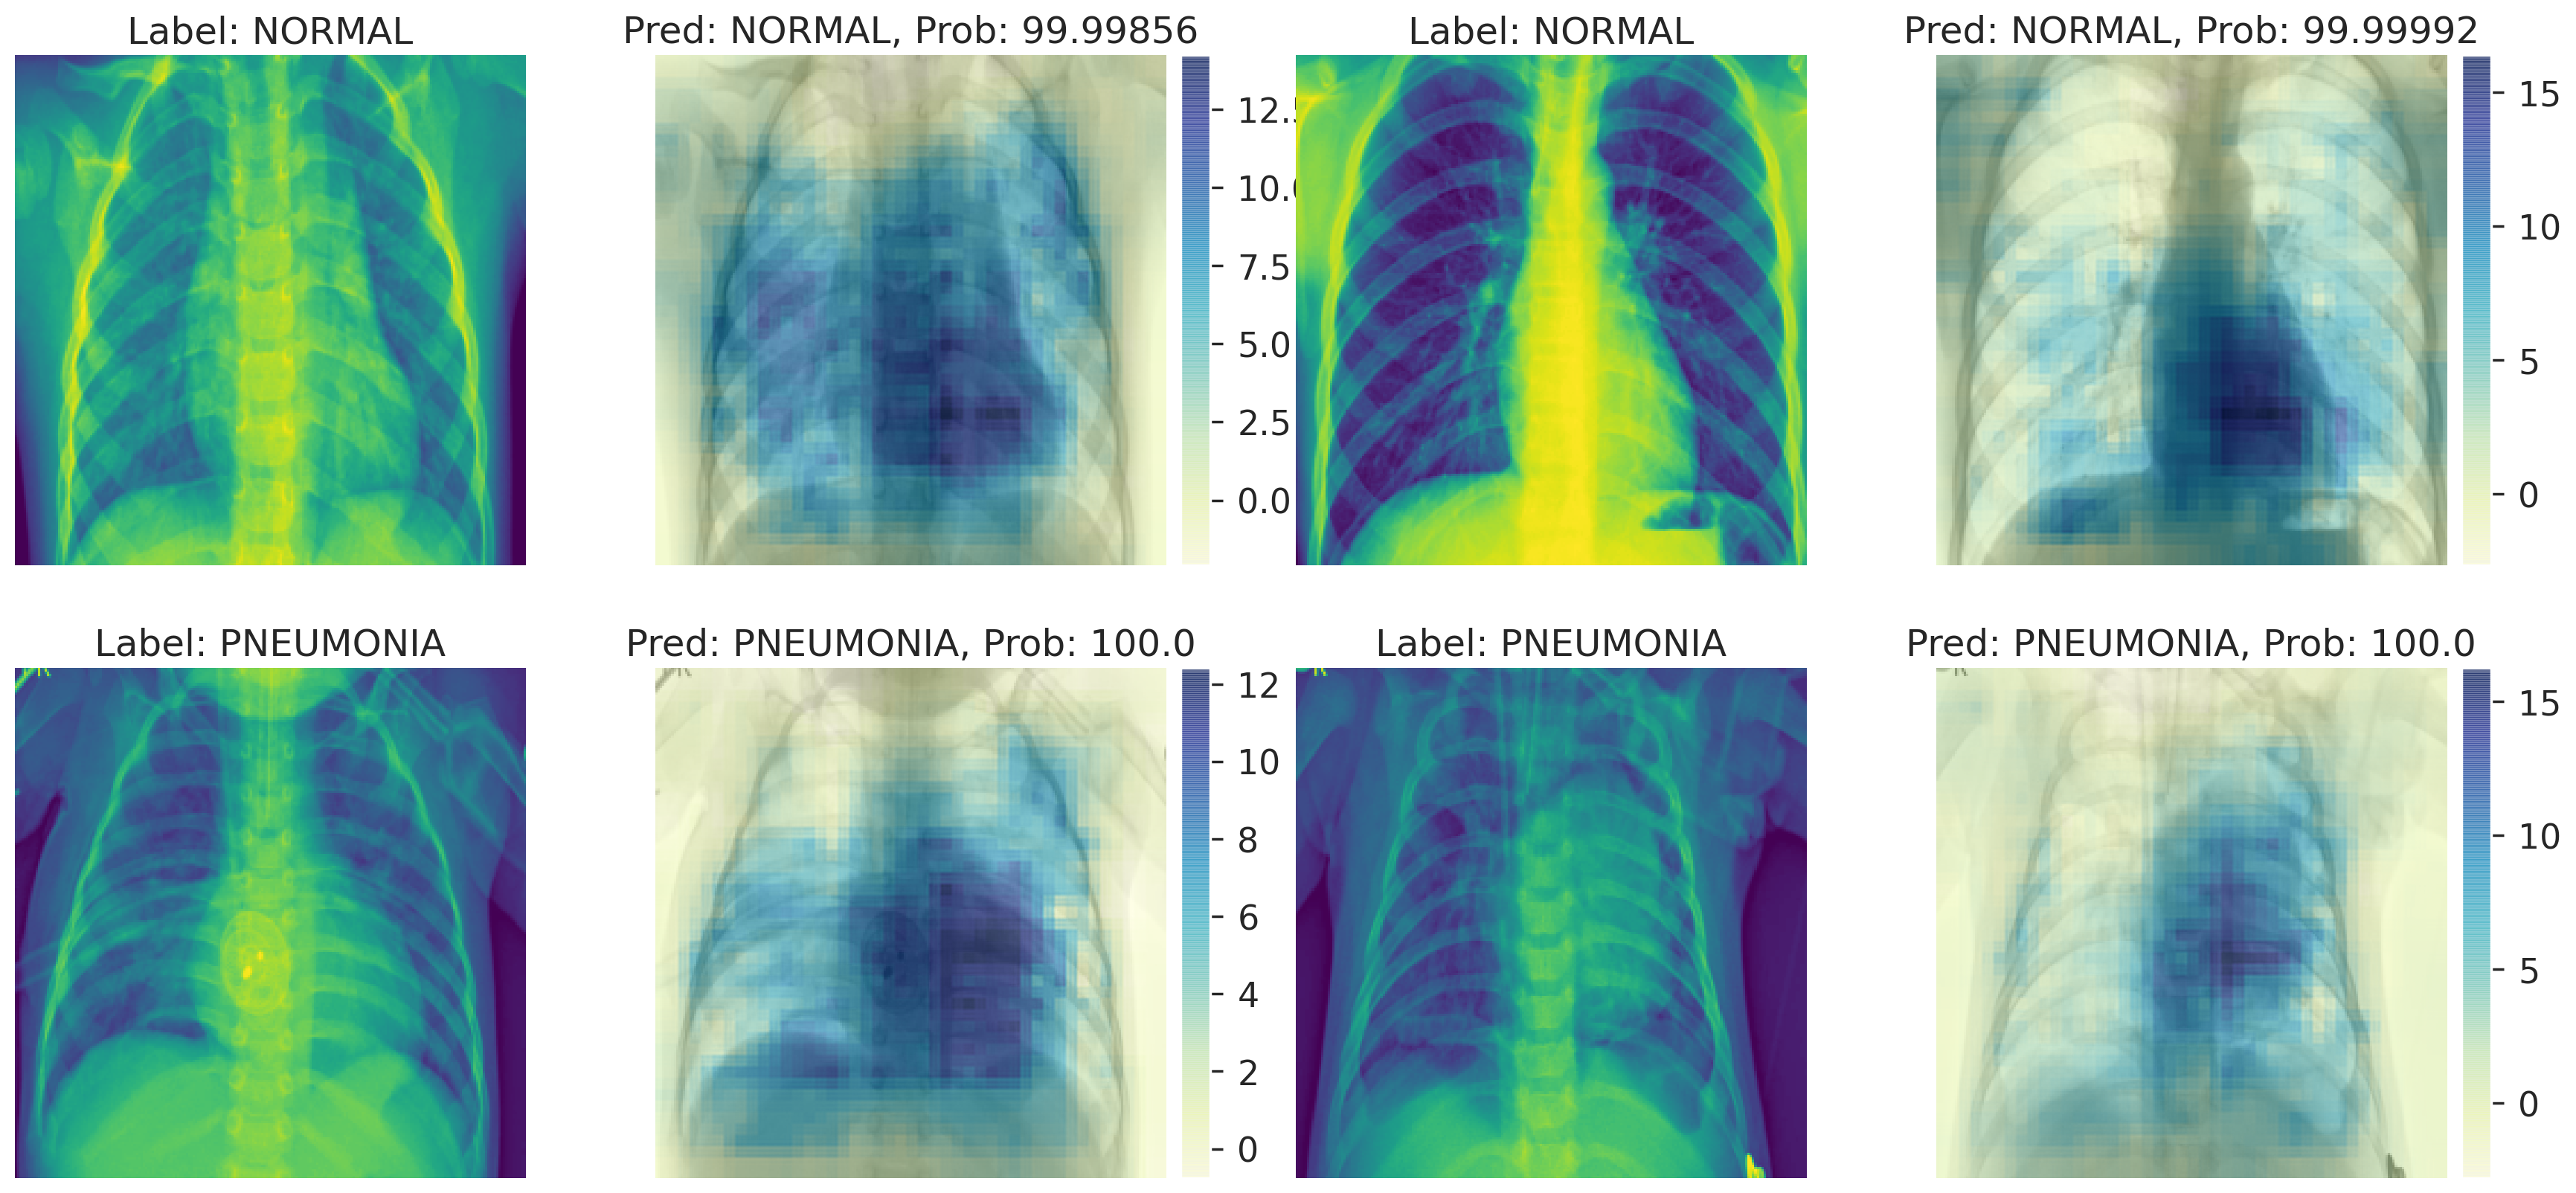

In [102]:
fig = plt.figure(figsize=(20,10), dpi=200)
i=0
for j, cls in enumerate([cls0,cls1]):
  for inp in cls:
    inp = inp.to(device).unsqueeze(1)
    outputs = vgg16(inp)
    pred_probs = F.softmax(outputs, 1)
    prob, pred_label_idx = torch.max(pred_probs, 1)
    pred_label_idx.squeeze_()

    # noise_tunnel.attribute(inp, n_samples=3, nt_type='smoothgrad_sq', target=pred_label_idx, stdevs=0.01)
    #attributions_ig = ig.attribute(inp, target=pred_label_idx, n_steps=200)
    attributions_ig = occlusion.attribute(inp,
                                          strides = (1, 10, 10),
                                          target=0,
                                          sliding_window_shapes=(1, 15, 15),
                                          baselines=0)
    #attributions_ig = saliency.attribute(inp, target=pred_label_idx)
    
    ax1 = fig.add_subplot(241+i*2)
    ax1.imshow((inp.squeeze().cpu().detach().numpy()), cmap='viridis')
    ax1.set_title(f'Label: {class_names[j]}')
    ax1.axis('off');

    ax2 = fig.add_subplot(242+i*2)
    ax2.imshow((inp.squeeze().cpu().detach().numpy()), cmap='Greys')
    im = ax2.imshow(attributions_ig.squeeze().cpu().detach().numpy(), alpha=0.6, cmap='YlGnBu', interpolation='sinc')
    ax2.set_title(f'Pred: {class_names[pred_label_idx.cpu().detach().numpy()]}, Prob: {round(prob.cpu().detach().numpy()[0]*100,5)}')
    ax2.axis('off');
    
    i+=1

    fig.subplots_adjust(right=0.95)
    box2 = np.array(ax2.get_position())
    cbar_ax = fig.add_axes([box2[1,0]+0.005 , box2[0,1], 0.01, box2[1,1]-box2[0,1]])
    fig.colorbar(im, cax=cbar_ax)